In [1]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# !pip install tqdm
# !pip install scikit-learn
# !pip install matplotlib

# DDAMFN++

The code below was adopted from the DDAMFN++ repository outlined below and altered to facilitate integration with the five datasets.

**LINK**: https://github.com/SainingZhang/DDAMFN

## Model Components

### Mixed Feature Network

In [2]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
import torch
import torch.nn as nn
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output
  

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

NON_LINEARITY = {
    'ReLU': nn.ReLU(inplace=True),
    'Swish': Swish(),
}        


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)

class swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class CoordAtt(nn.Module):
    def __init__(self, inp, oup, groups=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        mip = max(8, inp // groups)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.conv2 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.relu = h_swish()

    def forward(self, x):
        identity = x
        n,c,h,w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.relu(y) 
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        x_h = self.conv2(x_h).sigmoid()
        x_w = self.conv3(x_w).sigmoid()
        x_h = x_h.expand(-1, -1, h, w)
        x_w = x_w.expand(-1, -1, h, w)

        y = identity * x_w * x_h

        return y

        
class MDConv(Module):
    def __init__(self, channels, kernel_size, split_out_channels, stride):
        super(MDConv, self).__init__()
        self.num_groups = len(kernel_size)
        self.split_channels = split_out_channels
        self.mixed_depthwise_conv = nn.ModuleList()
        for i in range(self.num_groups):
            self.mixed_depthwise_conv.append(Conv2d(
                self.split_channels[i],
                self.split_channels[i],
                kernel_size[i],
                stride=stride,
                padding=kernel_size[i]//2,
                groups=self.split_channels[i],
                bias=False
            ))
        self.bn = BatchNorm2d(channels)
        self.prelu = PReLU(channels)            
       
    def forward(self, x):
        if self.num_groups == 1:
            return self.mixed_depthwise_conv[0](x)

        x_split = torch.split(x, self.split_channels, dim=1)
        x = [conv(t) for conv, t in zip(self.mixed_depthwise_conv, x_split)]
        x = torch.cat(x, dim=1)

        return x        
      
        
class Mix_Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1, kernel_size=[3,5,7], split_out_channels=[64,32,32]):
        super(Mix_Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = MDConv(channels=groups, kernel_size=kernel_size, split_out_channels=split_out_channels, stride=stride)
        self.CA = CoordAtt(groups, groups)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.CA(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output
          
class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)
        
class Mix_Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5], split_out_channels=[64,64]):
        super(Mix_Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Mix_Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups, kernel_size=kernel_size, split_out_channels=split_out_channels ))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)
        

class MixedFeatureNet(Module):
    def __init__(self, embedding_size=256, out_h=7, out_w=7):
        super(MixedFeatureNet, self).__init__()
        #112x112
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        #56x56
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Mix_Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, kernel_size=[3,5,7], split_out_channels=[64,32,32] )
        
        #28x28
        self.conv_3 = Mix_Residual(64, num_block=9, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5], split_out_channels=[96,32])
        self.conv_34 = Mix_Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256, kernel_size=[3,5,7],split_out_channels=[128,64,64] )
        
        #14x14
        self.conv_4 = Mix_Residual(128, num_block=16, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5], split_out_channels=[192,64])
        self.conv_45 = Mix_Depth_Wise(128, 256, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512*2, kernel_size=[3,5,7,9],split_out_channels=[128*2,128*2,128*2,128*2] )
        #7x7
        self.conv_5 = Mix_Residual(256, num_block=6, groups=512, kernel=(3, 3), stride=(1, 1), padding=(1, 1), kernel_size=[3,5,7], split_out_channels=[86*2,85*2,85*2])                
        self.conv_6_sep = Conv_block(256, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(out_h, out_w), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2_dw(out)
        out = self.conv_23(out)
        out = self.conv_3(out)
        out = self.conv_34(out)
        out = self.conv_4(out)
        out = self.conv_45(out)
        out = self.conv_5(out)
        out = self.conv_6_sep(out)
        out = self.conv_6_dw(out)
        out = self.conv_6_flatten(out)
        out = self.linear(out)
        out = self.bn(out)

        return l2_norm(out)

### DDAMFN++ Network

In [ ]:
from torch import nn
import torch
from torch.nn import Module
import os
class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = nn.Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
        
class DDAMNet(nn.Module):
    def __init__(self, num_class=7,num_head=2, pretrained=True):
        super(DDAMNet, self).__init__()

        net = MixedFeatureNet()
                
        if pretrained:
            net = torch.load(os.path.join('./pretrained/', "MFN_msceleb.pth"), weights_only=False)       
      
        self.features = nn.Sequential(*list(net.children())[:-4])
        self.num_head = num_head
        for i in range(int(num_head)):
            setattr(self,"cat_head%d" %(i), CoordAttHead())                  
      
        self.Linear = Linear_block(512, 512, groups=512, kernel=(7, 7), stride=(1, 1), padding=(0, 0))
        self.flatten = Flatten()      
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)
        
    def forward(self, x):
        x = self.features(x)
        heads = []
       
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        head_out =heads
        
        y = heads[0]
        
        for i in range(1,self.num_head):
            y = torch.max(y,heads[i])                     
        
        y = x*y
        y = self.Linear(y)
        y = self.flatten(y) 
        out = self.fc(y)        
        return out, x, head_out
        
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)
    def forward(self, x):
        return self.relu(x + 3) / 6
                      
class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)
    def forward(self, x):
        return x * self.sigmoid(x)

class CoordAttHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.CoordAtt = CoordAtt(512,512)
    def forward(self, x):
        ca = self.CoordAtt(x)
        return ca  
        
class CoordAtt(nn.Module):
    def __init__(self, inp, oup, groups=32):
        super(CoordAtt, self).__init__()
      
        self.Linear_h = Linear_block(inp, inp, groups=inp, kernel=(1, 7), stride=(1, 1), padding=(0, 0))        
        self.Linear_w = Linear_block(inp, inp, groups=inp, kernel=(7, 1), stride=(1, 1), padding=(0, 0))
        
        mip = max(8, inp // groups)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.conv2 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.relu = h_swish()
        self.Linear = Linear_block(oup, oup, groups=oup, kernel=(7, 7), stride=(1, 1), padding=(0, 0))
        self.flatten = Flatten() 

    def forward(self, x):
        identity = x
        n,c,h,w = x.size()
        x_h = self.Linear_h(x)
        x_w = self.Linear_w(x)
        x_w = x_w.permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.relu(y) 
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        x_h = self.conv2(x_h).sigmoid()
        x_w = self.conv3(x_w).sigmoid()
        x_h = x_h.expand(-1, -1, h, w)
        x_w = x_w.expand(-1, -1, h, w)
        
        y = x_w * x_h
 
        return y

### SAM Class

In [4]:
import torch

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

## DDAMFN++ Training

In [5]:
import os
import sys
from tqdm import tqdm
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms, datasets

from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import itertools
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
eps = sys.float_info.epsilon

class AttentionLoss(nn.Module):
    def __init__(self, ):
        super(AttentionLoss, self).__init__()
    
    def forward(self, x):
        num_head = len(x)
        loss = 0
        cnt = 0
        if num_head > 1:
            for i in range(num_head-1):
                for j in range(i+1, num_head):
                    mse = F.mse_loss(x[i], x[j])
                    cnt = cnt+1
                    loss = loss+mse
            loss = cnt/(loss + eps)
        else:
            loss = 0
        return loss     
 
def TrainDDAMFN_PP(data_directory, dataset_name, device, lr=5e-4, batch_size=128, patience=15, num_epochs=60, num_head=2, workers=16):

    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = True

    data_transforms = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
                transforms.RandomRotation(5),
                transforms.RandomCrop(112, padding=8)
            ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(scale=(0.02,0.25)),
        ])   

    train_dataset = datasets.ImageFolder(f'{data_directory}/train', transform = data_transforms)   

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size = batch_size,
                                            num_workers = workers,
                                            shuffle = True,  
                                            pin_memory = True,
                                            drop_last=True)
    
    print('Whole train set size:', train_dataset.__len__())

    data_transforms_val = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])   
  
    val_dataset = datasets.ImageFolder(f'{data_directory}/validation', transform = data_transforms_val)        
    
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size = batch_size,
                                            num_workers = workers,
                                            shuffle = False,  
                                            pin_memory = True,
                                            drop_last=True)
    
    print('Validation set size:', val_dataset.__len__())

    num_classes = len(train_dataset.classes)
    print(f"Number of classes: {num_classes}")

    model = DDAMNet(num_class=num_classes, num_head=num_head)
    model.to(device)

    #-----------------------------------------------
    # Calculate class weights for the training dataset (balanced weights) - Modification
    labels = np.array(train_dataset.targets)
    classes = np.unique(labels)
    class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)

    print("Class weights: ", class_weights)

    criterion_cls = torch.nn.CrossEntropyLoss(weight=class_weights)

    criterion_at = AttentionLoss()
    #-----------------------------------------------

    optimizer = SAM(model.parameters(), torch.optim.Adam, lr=lr, rho=0.05, adaptive=False)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    patience_counter = 0
    best_val_acc = 0

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        correct_sum = 0
        iter_cnt = 0
        model.train()

        # Initialize progress bar once at start of epoch
        train_progress = tqdm(total=len(train_dataset), 
                            desc=f"Epoch {epoch}/{num_epochs} Training", 
                            unit='img', 
                            leave=True,
                            postfix={'loss': '?', 'acc': '?'})  # Initial placeholder

        for imgs, targets in train_loader:
            optimizer.zero_grad()

            imgs = imgs.to(device)
            targets = targets.to(device)
            
            out,feat,heads = model(imgs)
            loss = criterion_cls(out,targets) + 0.1*criterion_at(heads)  

            loss.backward()
            optimizer.first_step(zero_grad=True)
            
            imgs = imgs.to(device)
            targets = targets.to(device)
            
            out,feat,heads = model(imgs)
            loss = criterion_cls(out,targets) + 0.1*criterion_at(heads) 
            # optimizer.zero_grad() #Remove?
            loss.backward()
            optimizer.second_step(zero_grad=True)            
                                    
            running_loss += loss
            _, predicts = torch.max(out, 1)
            correct_num = torch.eq(predicts, targets).sum()
            correct_sum += correct_num
            iter_cnt += 1
        
            # Update progress bar
            train_progress.update(len(imgs))
            train_progress.set_postfix({
                'loss': f"{running_loss/iter_cnt:.3f}",
                'acc': f"{correct_sum/(train_progress.n)*100:.1f}%",
                'lr': f"{optimizer.param_groups[0]['lr']:.1e}"
            }, refresh=False)

        train_progress.close()

        acc = correct_sum.float() / float(train_dataset.__len__())
        running_loss = running_loss/iter_cnt
        tqdm.write('[Epoch %d] Training accuracy: %.4f. Loss: %.3f. LR %.6f' % (epoch, acc, running_loss,optimizer.param_groups[0]['lr']))

        with torch.no_grad():
            running_loss = 0.0
            iter_cnt = 0
            bingo_cnt = 0
            sample_cnt = 0
            
            # for calculating balanced accuracy
            y_true = []
            y_pred = []
 
            model.eval()

            # Initialize validation progress bar
            val_progress = tqdm(total=len(val_dataset), 
                       desc=f"Epoch {epoch} Validation",
                       unit='img',
                       leave=False,
                       postfix={'val_loss': '?', 'val_acc': '?'})
    
            for (imgs, targets) in val_loader:
                imgs = imgs.to(device)
                targets = targets.to(device)
                
                out,feat,heads = model(imgs)
                loss = criterion_cls(out,targets)+ 0.1*criterion_at(heads) 
                loss_item = loss.item() #---

                running_loss += loss
                _, predicts = torch.max(out, 1)

                correct_num  = torch.eq(predicts,targets)
                current_batch_size = imgs.size(0) #--
                
                bingo_cnt += correct_num.sum().cpu()
                sample_cnt += imgs.size(0)
                
                y_true.append(targets.cpu().numpy())
                y_pred.append(predicts.cpu().numpy())

                # Update progress bar
                val_progress.update(current_batch_size)
                val_progress.set_postfix({
                    'val_loss': f"{running_loss/(iter_cnt+1):.3f}",
                    'val_acc': f"{(bingo_cnt/sample_cnt)*100:.1f}%"
                }, refresh=False)

                if iter_cnt == 0:
                    all_predicted = predicts
                    all_targets = targets
                else:
                    all_predicted = torch.cat((all_predicted, predicts),0)
                    all_targets = torch.cat((all_targets, targets),0)                  
                iter_cnt+=1

            val_progress.close()  
            running_loss = running_loss/iter_cnt   
            scheduler.step()

            acc = bingo_cnt.float()/float(sample_cnt)
            acc = np.around(acc.numpy(),4)

            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            balanced_acc = np.around(balanced_accuracy_score(y_true, y_pred),4)

            tqdm.write("[Epoch %d] Validation accuracy:%.4f. bacc:%.4f. Loss:%.3f" % (epoch, acc, balanced_acc, running_loss))


            if acc > best_val_acc:
                best_val_acc = acc
                patience_counter = 0
                os.makedirs("Models", exist_ok=True)
                torch.save({'iter': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'workers': workers,
                            'num_head': num_head,},
                            os.path.join('Models', f"DDAMFNPP_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_P_{patience}_E_{num_epochs}_H_{num_head}_W_{workers}.pth"))
                tqdm.write('Model saved.')
            else:    
                patience_counter += 1
                print(f"No improvement in validation accuracy for {patience_counter} epochs.")

            if patience_counter > patience:
                print("Stopping early due to lack of improvement in validation accuracy.")
                break

    tqdm.write("best_acc:" + str(best_val_acc))

### Training the Model

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

dataset_name, data_directory = 'FER_Aligned', '../../Datasets/FER_Structured_Aligned' # 11hr | 71% Acc on Test Set | Epoch 68
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/RAF-DB_Structured_Aligned' # 4hr 10mINS | 89% Acc On Test Set | Epoch 50
# dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/AffectNet_Structured_Aligned' # 6hr 35m | 61% Acc On Test Set | Epoch 34

lr = 0.001
batch_size = 16
patience = 15
num_epochs = 300
num_head = 2 # best value according to paper    
workers = 16 # arbitrary value, shouldnt affect results

TrainDDAMFN_PP(data_directory, dataset_name, device, lr, batch_size, patience, num_epochs, num_head, workers)

## DDAMFN++ Testing

In [7]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

def TestDDAMFN(data_directory, model_path, batch_size=15, ignored_labels=[]):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} device")

    transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])   

    state_dict = torch.load(model_path, weights_only=True)
    final_fc_layer = [k for k in state_dict['model_state_dict'].keys() if 'fc' in k and 'weight' in k][-1]
    num_classes = state_dict['model_state_dict'][final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    num_head = state_dict['num_head']
    print(f"Number of attention heads: {num_head}")

    model = DDAMNet(num_class=num_classes, num_head=num_head).to(device)
    model.load_state_dict(state_dict['model_state_dict'])
    model.eval()

    workers = state_dict['workers']

    test_dataset = datasets.ImageFolder(f'{data_directory}/test', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=workers,
                             shuffle=False, pin_memory=True)

    all_preds = []
    all_labels = []
    all_probs = []

    # Get a mapping from dataset class index to label
    label_map = test_dataset.class_to_idx
    idx_to_class = {v: k for k, v in label_map.items()}

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Filter ignored labels
            mask = ~np.isin(labels.numpy(), ignored_labels)
            if mask.sum() == 0:
                continue

            inputs = inputs[mask].to(device)
            labels = labels[mask].to(device)

            outputs, feat, heads = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    # Replace invalid predictions
    test_labels_set = set(np.unique(all_labels))
    fixed_preds = []
    for i in range(len(all_probs)):
        sorted_indices = np.argsort(all_probs[i])[::-1]
        for pred in sorted_indices:
            if pred in test_labels_set:
                fixed_preds.append(pred)
                break

    fixed_preds = np.array(fixed_preds)

    # Metrics
    accuracy = accuracy_score(all_labels, fixed_preds)
    precision_weighted = precision_score(all_labels, fixed_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, fixed_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, fixed_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, fixed_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, fixed_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, fixed_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, fixed_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, fixed_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, fixed_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, fixed_preds, zero_division=0)
    labels_for_cm = sorted(test_labels_set)
    cm = confusion_matrix(all_labels, fixed_preds, labels=labels_for_cm)

    # Output
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


### Deriving Metrics across all datasets

Using cuda device
Number of classes: 7
Number of attention heads: 2
Test Accuracy: 0.4576271186440678
Precision (Weighted): 0.6445116069217408
Precision (Macro): 0.4467602969004717
Precision (Micro): 0.4576271186440678
Recall (Weighted): 0.4576271186440678
Recall (Macro): 0.4526325178173156
Recall (Micro): 0.4576271186440678
F1 Score (Weighted): 0.5095227843558816
F1 Score (Macro): 0.40512466519287055
F1 Score (Micro): 0.4576271186440678

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.73      0.50        81
           1       0.14      0.17      0.16        80
           2       0.05      0.41      0.08        37
           3       0.92      0.46      0.61       592
           4       0.43      0.54      0.48       239
           5       0.64      0.45      0.53       165
           6       0.57      0.40      0.47       340

    accuracy                           0.46      1534
   macro avg       0.45      0.45      0.41  

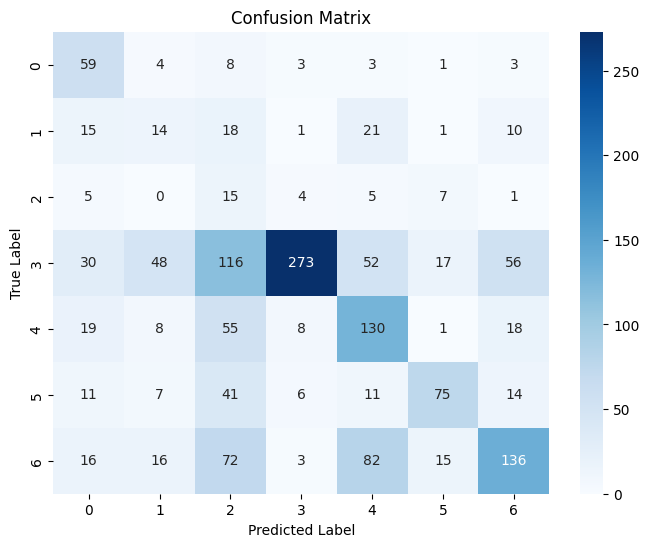

In [ ]:
# dataset_name, data_directory = 'FER_Aligned', '../../Datasets/FER_Structured_Aligned'
# dataset_name, data_directory = 'FER_Aligned', '../../Datasets/AffectNet_Structured_Aligned'
# dataset_name, data_directory = 'FER_Aligned', '../../Datasets/CK+_Structured_Aligned'
# dataset_name, data_directory = 'FER_Aligned', '../../Datasets/JAFFE_Structured_Aligned'
dataset_name, data_directory = 'FER_Aligned', '../../Datasets/RAF-DB_Structured_Aligned'

lr = 0.001
batch_size = 16
patience = 15
num_epochs = 300
num_head = 2
workers = 16

model_path = f"ModelsReadyForComparison/DDAMFNPP_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_P_{patience}_E_{num_epochs}_H_{num_head}_W_{workers}.pth"

TestDDAMFN(data_directory, model_path, batch_size, ignored_labels = [7])

Using cuda device
Number of classes: 8
Number of attention heads: 2
Test Accuracy: 0.6851368970013038
Precision (Weighted): 0.7707624465361355
Precision (Macro): 0.5695970762154747
Precision (Micro): 0.6851368970013038
Recall (Weighted): 0.6851368970013038
Recall (Macro): 0.6480440694004154
Recall (Micro): 0.6851368970013038
F1 Score (Weighted): 0.7137421659336395
F1 Score (Macro): 0.5738761624438614
F1 Score (Micro): 0.6851368970013038

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.73      0.47        81
           1       0.36      0.51      0.42        80
           2       0.18      0.68      0.29        37
           3       0.98      0.77      0.86       592
           4       0.74      0.69      0.71       239
           5       0.60      0.51      0.55       165
           6       0.77      0.65      0.71       340

    accuracy                           0.69      1534
   macro avg       0.57      0.65      0.57   

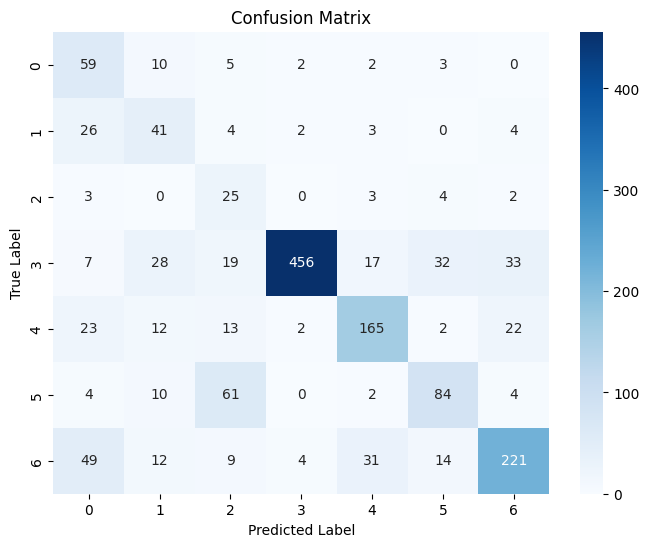

In [25]:
# dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/AffectNet_Structured_Aligned'
# dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/FER_Structured_Aligned'
# dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/CK+_Structured_Aligned'
# dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/JAFFE_Structured_Aligned'
dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/RAF-DB_Structured_Aligned'

lr = 0.001
batch_size = 16
patience = 15
num_epochs = 300
num_head = 2
workers = 16

model_path = f"ModelsReadyForComparison/DDAMFNPP_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_P_{patience}_E_{num_epochs}_H_{num_head}_W_{workers}.pth"

TestDDAMFN(data_directory, model_path, batch_size)

Using cuda device
Number of classes: 7
Number of attention heads: 2
Test Accuracy: 0.36363636363636365
Precision (Weighted): 0.424931129476584
Precision (Macro): 0.32702020202020204
Precision (Micro): 0.36363636363636365
Recall (Weighted): 0.36363636363636365
Recall (Macro): 0.3125
Recall (Micro): 0.36363636363636365
F1 Score (Weighted): 0.32020114032309155
F1 Score (Macro): 0.2622677119628339
F1 Score (Micro): 0.36363636363636365

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         1
           3       0.75      0.25      0.38        12
           4       0.21      0.88      0.34         8
           5       1.00      0.75      0.86         8

    accuracy                           0.36        44
   macro avg       0.33      0.31      0.26        44
weighted avg       0.42      0.36      0.32        4

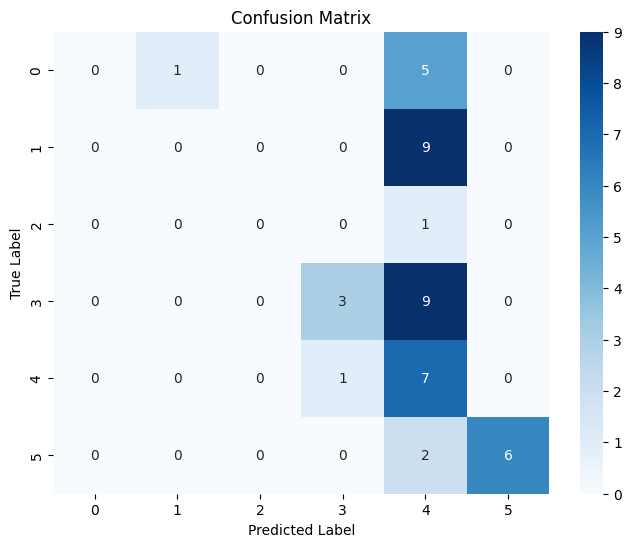

In [29]:
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/RAF-DB_Structured_Aligned'
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/FER_Structured_Aligned'
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/AffectNet_Structured_Aligned'
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/CK+_Structured_Aligned'
dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/JAFFE_Structured_Aligned'

lr = 0.001
batch_size = 16
patience = 15
num_epochs = 300
num_head = 2
workers = 16

model_path = f"ModelsReadyForComparison/DDAMFNPP_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_P_{patience}_E_{num_epochs}_H_{num_head}_W_{workers}.pth"

TestDDAMFN(data_directory, model_path, batch_size, ignored_labels = [7])